<a href="https://colab.research.google.com/github/alx87grd/DimensionlessPolicies/blob/main/car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dimentionless policies for longitudinal cars


In [ ]:
!git clone https://github.com/SherbyRobotics/pyro
import sys
sys.path.append('/content/pyro')

from IPython import display

fatal: destination path 'pyro' already exists and is not an empty directory.


### Resolution selection

In [ ]:
# res = 'test'
res = 'plus'
#res = 'hi'

# Source Code

In [ ]:
##############################################################################
import numpy as np
import matplotlib.pyplot as plt
##############################################################################
from pyro.dynamic  import longitudinal_vehicule
from pyro.planning import discretizer
from pyro.analysis import costfunction
from pyro.planning import dynamicprogramming
from pyro.analysis import graphical
##############################################################################



def case( length , x_c_star , y_c_star , x_w_star , case_name = 'test ', show = True, rax = None , rax2 = None, res = 'reg', legend = 1):


    gravity = 9.8

    # context
    x_c = x_c_star * length
    y_c = y_c_star * length
    x_w = x_w_star * length

    # additionnal domain
    x_max = 10 * length
    v_max = 2 * np.sqrt( gravity * length )
    t_max = 10 * x_max / v_max
    s_max = 0.07
    j_max = t_max * ( ( x_max / x_w  ) **2 + s_max ** 2 )


    print('\n\nCase :' + case_name )
    print('----------------------------------------------------')
    print(' l=',length,' x_c=', x_c, ' y_c=', y_c,'x_w=', x_w)

    ################################
    # Dynamic system definition
    ################################

    sys  = longitudinal_vehicule.LongitudinalFrontWheelDriveCarWithWheelSlipInput()

    # Model param
    sys.lenght  = length          # distance between front wheel and back wheel [m]
    sys.xc      = x_c          # distance from back wheel to c.g.  [m]
    sys.yc      = y_c       # height from ground to c.g.  [m]

    sys.gravity = gravity       # gravity constant [N/kg]

    sys.mass    = 1.       # total car mass [kg]
    sys.rho     = 1.      # air density [kg/m3]
    sys.cdA     = 0.    # drag coef time area [m2]

    # Ground traction curve parameters
    sys.mu_max   = 1.0
    sys.mu_slope = 70.

    sys.u_ub[0]  = + s_max
    sys.u_lb[0]  = - s_max

    sys.x_ub = np.array([ + x_max , + v_max])
    sys.x_lb = np.array([ - x_max , - v_max])

    ################################
    # Discritized grid
    ################################

    if res == 'test' :

        dt = 0.5
        nx = 21
        nu = 3

    elif res == 'plus' :

        dt = 0.05
        nx = 301
        nu = 101

    elif res == 'hi' :

        dt = 0.025
        nx = 501
        nu = 101

    else:

        dt = 0.05
        nx = 101
        nu = 21

    grid_sys = discretizer.GridDynamicSystem( sys , [nx,nx] , [nu] , dt , True )

    ################################
    # Cost function
    ################################

    qcf = costfunction.QuadraticCostFunction.from_sys(sys)

    qcf.xbar = np.array([ 0 , 0 ]) # target

    qcf.INF  = j_max


    qcf.Q[0,0] = (1./x_w) ** 2
    qcf.Q[1,1] = 0.0

    qcf.R[0,0] = 1.0

    ################################
    # Computing optimal policy
    ################################

    dp = dynamicprogramming.DynamicProgrammingWithLookUpTable( grid_sys, qcf )

    steps = int( t_max / dt )

    dp.compute_steps( steps )


    #grid_sys.fontsize = 10
    # qcf.INF  = 0.1 * qcf.INF
    dp.clean_infeasible_set()

    dp.plot_policy()


    ##################################
    # Fig param
    ##################################

    dpi      = 300
    fontsize = 10
    figsize  = (4, 3)

    # ##################################
    # # Dimensional policy plot
    # ##################################

    fig = plt.figure( figsize = figsize, dpi=dpi, frameon=True)
    fig.canvas.manager.set_window_title( 'dimentionless policy' )
    ax  = fig.add_subplot(1, 1, 1)

    xname = r'$x  \; [m]$'
    yname = r'$\dot{x} \; [m/sec]$'
    zname = r'$s \; [-]$'

    sys.state_label[0] = r'$x$'
    sys.state_label[1] = r'$\dot{x}$'
    sys.input_label[0] = r'$s$'

    xrange = 50
    yrange = 15
    zrange = 0.08

    ax.set_ylabel( yname, fontsize = fontsize )
    ax.set_xlabel( xname, fontsize = fontsize )

    x_level = grid_sys.x_level[ 0 ]
    y_level = grid_sys.x_level[ 1 ]


    u         = grid_sys.get_input_from_policy( dp.pi , 0 )
    J_grid_nd = grid_sys.get_grid_from_array( u )
    J_grid_2d = grid_sys.get_2D_slice_of_grid( J_grid_nd , 0 , 1 )

    mesh = ax.pcolormesh( x_level,
                          y_level,
                          J_grid_2d.T,
                          shading='gouraud',
                          cmap = 'bwr',
                          vmin = -zrange,
                          vmax = zrange,
                          rasterized = True )

    ax.tick_params( labelsize = fontsize )
    ax.grid(True)
    ax.set_ylim( -yrange, +yrange)
    ax.set_xlim( -xrange, xrange)

    cbar = fig.colorbar( mesh )

    cbar.set_label(zname, fontsize = fontsize , rotation = 90 )

    fig.tight_layout()
    #fig.show()
    fig.savefig( case_name + '_policy.pdf')
    # fig.savefig( case_name + '_policy.png')
    # fig.savefig( case_name + '_policy.jpg')

    if show:
        plt.show()
    else:
        plt.close( fig )

    ##################################
    # Dimensionless policy plot
    ##################################

    fig = plt.figure( figsize= figsize, dpi=dpi, frameon=True)
    fig.canvas.manager.set_window_title( 'dimentionless policy' )
    ax  = fig.add_subplot(1, 1, 1)

    xname = r'$x^*$'#self.sys.state_label[x] #+ ' ' + self.sys.state_units[x]
    yname = r'$\dot{x}^* = \frac{\dot{x}}{\sqrt{gl}}$'#self.sys.state_label[y] #+ ' ' + self.sys.state_units[y]
    zname = r'$s$'

    ax.set_ylabel(yname, fontsize = fontsize )
    ax.set_xlabel(xname, fontsize = fontsize )

    x_level = grid_sys.x_level[ 0 ] * 1./length
    y_level = grid_sys.x_level[ 1 ] * (1 / np.sqrt( gravity * length ))


    u = grid_sys.get_input_from_policy( dp.pi , 0 )

    u2 =  u

    J_grid_nd = grid_sys.get_grid_from_array( u2 )

    J_grid_2d = grid_sys.get_2D_slice_of_grid( J_grid_nd , 0 , 1 )

    mesh = ax.pcolormesh( x_level,
                          y_level,
                          J_grid_2d.T,
                          shading='gouraud',
                          cmap = 'bwr',
                          vmin = -zrange,
                          vmax = zrange,
                          rasterized = True )

    ax.tick_params( labelsize = fontsize )
    ax.grid(True)

    cbar = fig.colorbar( mesh )

    cbar.set_label(zname, fontsize = fontsize , rotation = 90 )

    fig.tight_layout()
    #fig.show()
    fig.savefig( case_name + '_dimpolicy.pdf')
    # fig.savefig( case_name + '_dimpolicy.png')
    # fig.savefig( case_name + '_dimpolicy.jpg')


    # ##################################
    # # Trajectory plot
    # ##################################

    ctl = dp.get_lookup_table_controller()

    # Simulation
    cl_sys = ctl + sys
    cl_sys.x0   = np.array([-x_max * 0.5, 0.])
    cl_sys.compute_trajectory( 10 , 6001, 'euler')

    tp = graphical.TrajectoryPlotter( sys )
    tp.fontsize = fontsize
    tp.plot( cl_sys.traj , 'xu' , show = False )
    tp.plots[0].set_ylim([-15.5, 15.5])
    tp.plots[1].set_ylim([-15.5, 15.5])
    tp.plots[2].set_ylim([-zrange, zrange])
    tp.fig.savefig( case_name + '_traj.pdf')

    # Simulation
    cl_sys = ctl + sys
    cl_sys.x0   = np.array([x_max * 0.5, 0.])
    cl_sys.compute_trajectory( 10 , 6001, 'euler')

    tp = graphical.TrajectoryPlotter( sys )
    tp.fontsize = fontsize
    tp.plot( cl_sys.traj , 'xu' , show = False )
    tp.plots[0].set_ylim([-15.5, 15.5])
    tp.plots[1].set_ylim([-15.5, 15.5])
    tp.plots[2].set_ylim([-zrange, zrange])
    tp.fig.savefig( case_name + '_traj2.pdf')
    # tp.fig.savefig( case_name + '_traj.png')
    # tp.fig.savefig( case_name + '_traj.jpg')

    if show:
        plt.show()
    else:
        plt.close( tp.fig )

    # cl_sys.plot_trajectory('xu')
    # cl_sys.plot_phase_plane_trajectory()

    return dp , cl_sys



# Main Figures

## computation



Case :car1
----------------------------------------------------
 l= 2.0  x_c= 1.0  y_c= 1.0 x_w= 40.0

Generating a mesh for: Front Wheel Drive Car
---------------------------------------------------
State space dimensions: 2  Input space dimension: 1
Number of nodes: 90601  Number of actions: 101
Number of node-action pairs: 9150701
---------------------------------------------------
Computing nodes..  completed in 0.31 sec
Computing actions..  completed in 0.00 sec
Computing x_next array.. 10000/90601 nodes computed in 63.21 sec
Computing x_next array.. 20000/90601 nodes computed in 122.20 sec
Computing x_next array.. 30000/90601 nodes computed in 181.59 sec
Computing x_next array.. 40000/90601 nodes computed in 242.06 sec
Computing x_next array.. 50000/90601 nodes computed in 303.40 sec
Computing x_next array.. 60000/90601 nodes computed in 366.19 sec
Computing x_next array.. 70000/90601 nodes computed in 426.17 sec
Computing x_next array.. 80000/90601 nodes computed in 486.89 sec

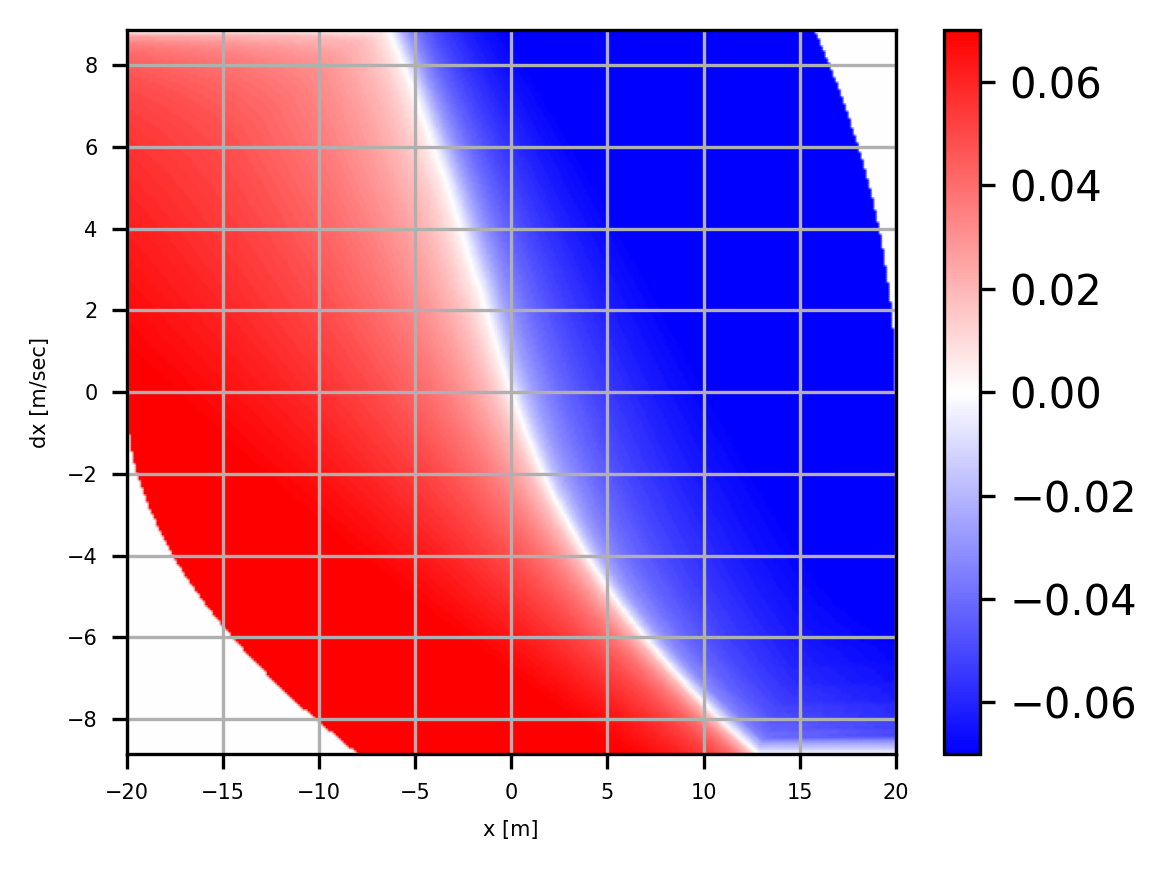

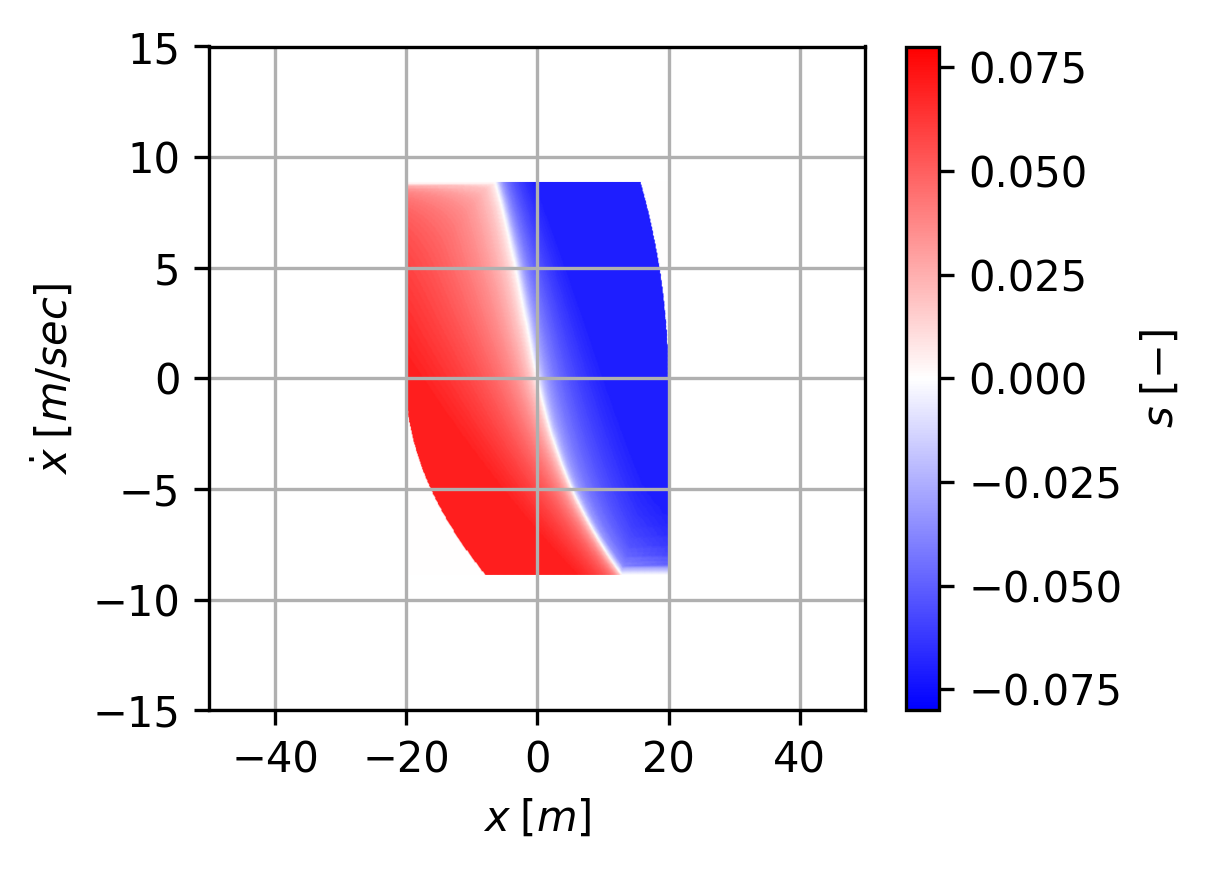

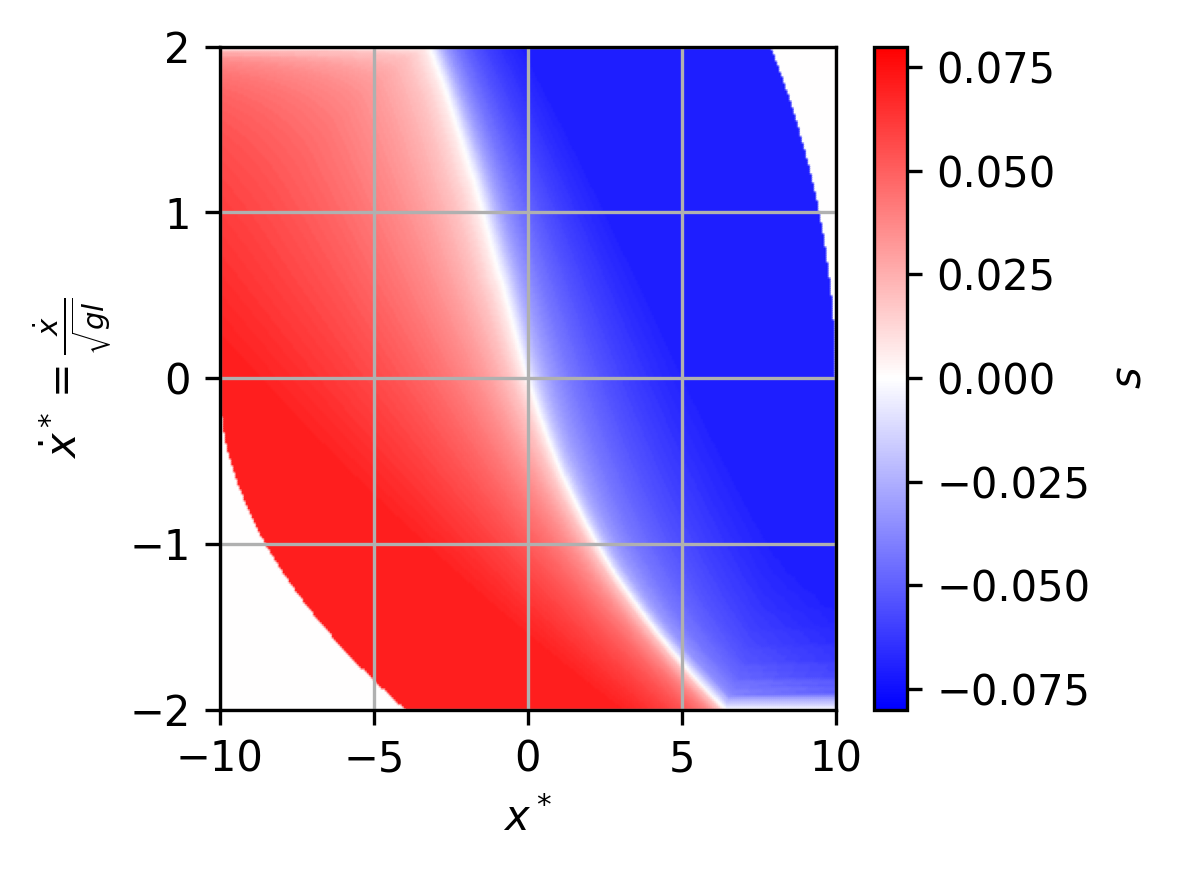

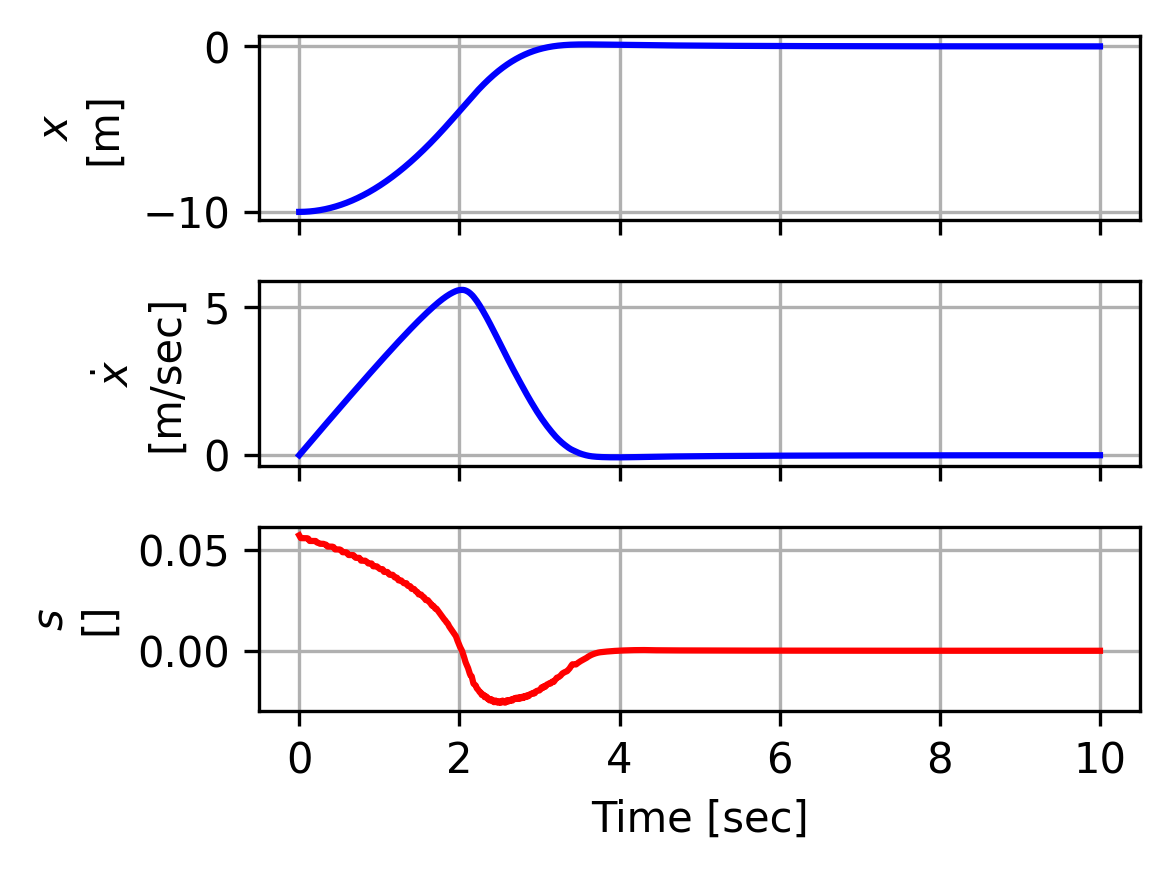

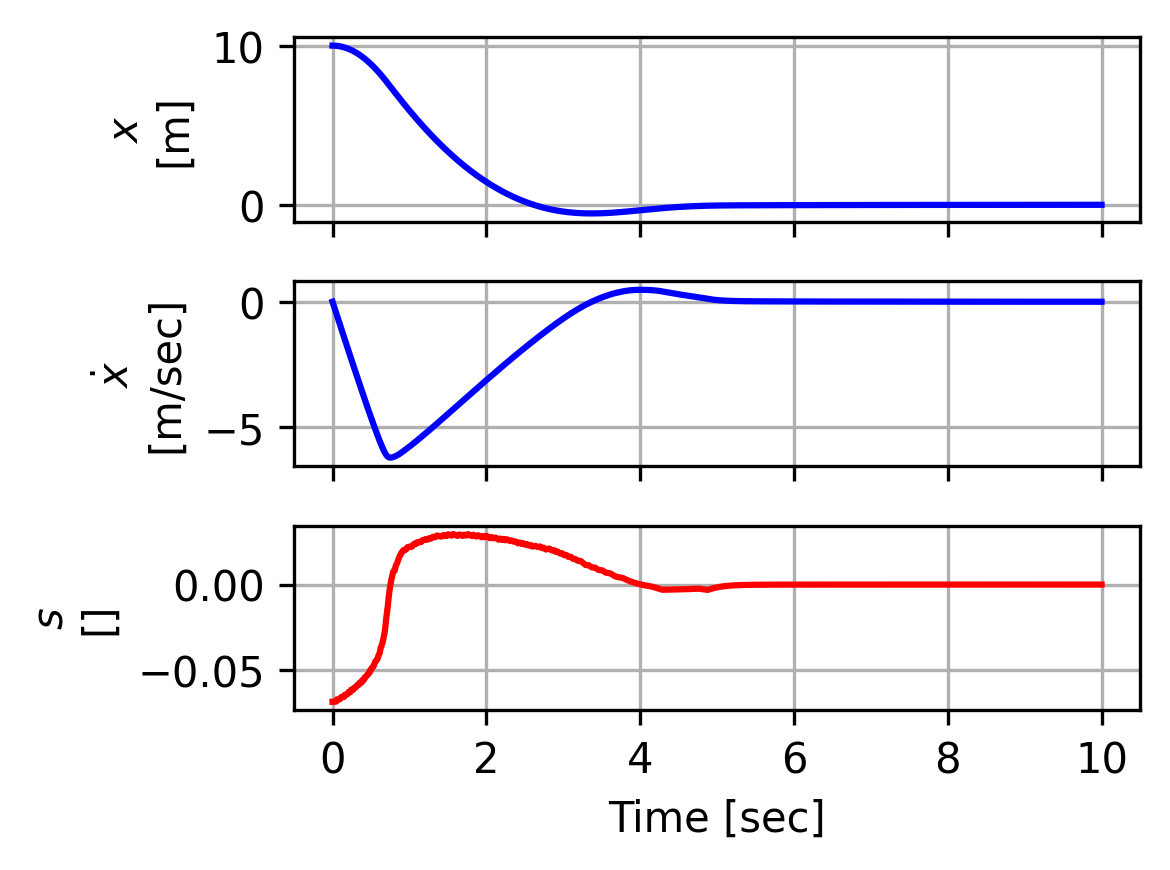

In [ ]:
dp , cl_sys = case( length = 2.0 , x_c_star = 0.5 , y_c_star = 0.5 , x_w_star = 20.0 , case_name = 'car1', res = res)
# dp , cl_sys = case( length = 1.0 , x_c_star = 0.5 , y_c_star = 0.5 , x_w_star = 20.0 , case_name = 'car2', res = res)
# dp , cl_sys = case( length = 3.0 , x_c_star = 0.5 , y_c_star = 0.5 , x_w_star = 20.0 , case_name = 'car3', res = res)

# dp , cl_sys = case( length = 2.0 , x_c_star = 0.5 , y_c_star = 1.5 , x_w_star = 10.0 , case_name = 'car4', res = res)
# dp , cl_sys = case( length = 1.0 , x_c_star = 0.5 , y_c_star = 1.5 , x_w_star = 10.0 , case_name = 'car5', res = res)
# dp , cl_sys = case( length = 3.0 , x_c_star = 0.5 , y_c_star = 1.5 , x_w_star = 10.0 , case_name = 'car6', res = res)

# dp , cl_sys = case( length = 2.0 , x_c_star = 0.5 , y_c_star = 0.1 , x_w_star = 2.0 , case_name = 'car7', res = res)
# dp , cl_sys = case( length = 1.0 , x_c_star = 0.5 , y_c_star = 0.1 , x_w_star = 2.0 , case_name = 'car8', res = res)
# dp , cl_sys = case( length = 3.0 , x_c_star = 0.5 , y_c_star = 0.1 , x_w_star = 2.0 , case_name = 'car9', res = res)


## Output

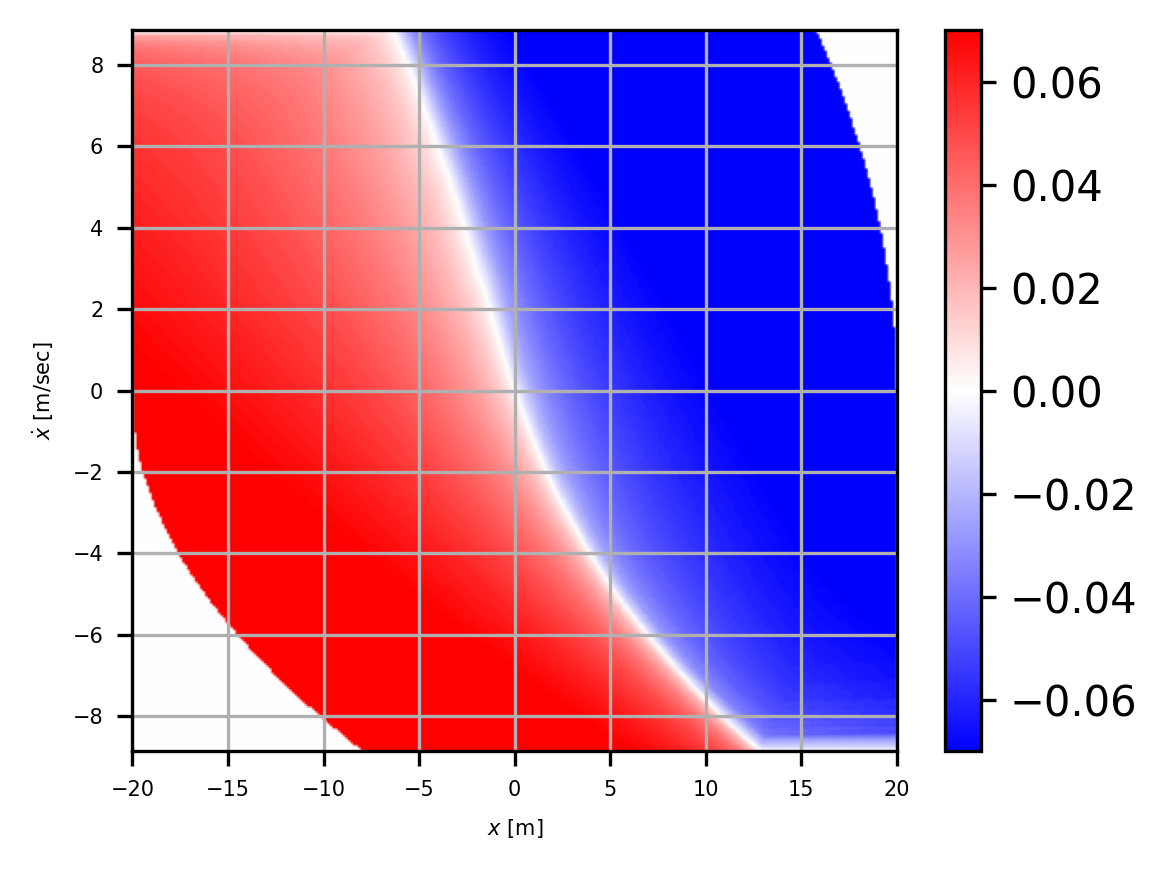

In [ ]:
dp.plot_policy()

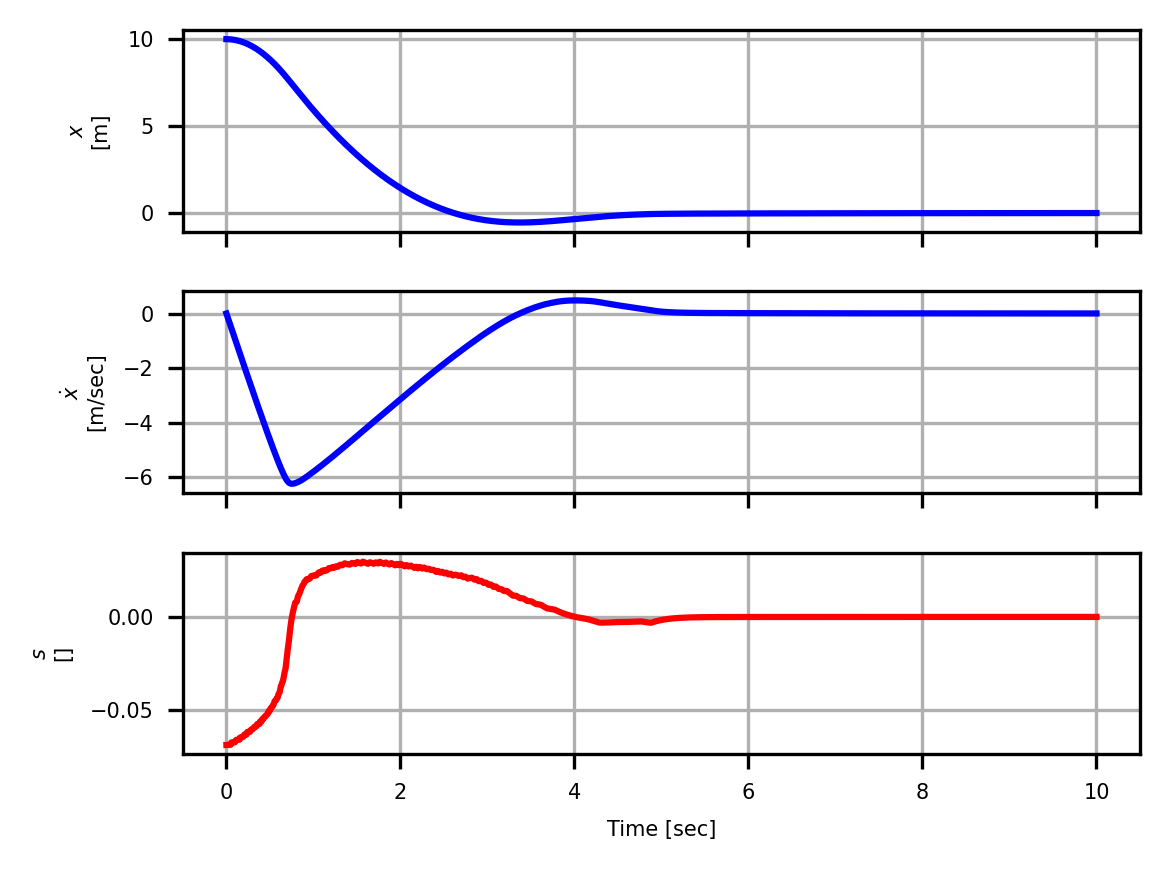

(<Figure size 1200x900 with 3 Axes>,
 array([<Axes: ylabel='$x$\n[m]'>, <Axes: ylabel='$\\dot{x}$\n[m/sec]'>,
        <Axes: xlabel='Time [sec]', ylabel='$s$\n[]'>], dtype=object))

In [ ]:
cl_sys.plot_trajectory('xu')

In [ ]:
ani  = cl_sys.generate_simulation_html_video()
html = display.HTML( ani )
display.display(html)